In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import librosa
import librosa.display

import tensorflow as tf

In [2]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
from IPython.display import Audio

## Load Data

In [4]:
from SimpleSpeechCommands import get_word_dict, read_list, load_data
from SimpleSpeechCommands import append_examples,partition_directory

In [5]:
word_to_label,label_to_word = get_word_dict()
path_dataset = '/home/edoardobucheli/Datasets/SpeechCommands_v0.01/train/audio/'
sr = 16000
file_length = 16000

In [6]:
training_files = read_list(path_dataset,'training_files.txt')
validation_files = read_list(path_dataset,'validation_files.txt')
testing_files = read_list(path_dataset,'testing_files.txt')

In [7]:
x_train,y_train = load_data(training_files,sr,file_length,path_dataset,word_to_label)
x_val,y_val = load_data(validation_files,sr,file_length,path_dataset,word_to_label)
x_test,y_test = load_data(testing_files,sr,file_length,path_dataset,word_to_label)

100%|██████████| 3430/3430 [00:01<00:00, 3054.41it/s]


In [8]:
backgrounds = partition_directory(path_dataset,'_background_noise_',sr,file_length)

In [9]:
x_train,y_train = append_examples(x_train,y_train,backgrounds[:300],11)
x_val,y_val = append_examples(x_val,y_val,backgrounds[300:320],11)
x_test,y_test = append_examples(x_test,y_test,backgrounds[320:],11)

In [10]:
from sklearn.utils import shuffle

In [11]:
x_train,y_train = shuffle(x_train,y_train)
x_val,y_val = shuffle(x_val,y_val)
x_test,y_test = shuffle(x_test,y_test)

In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(25412, 16000)
(25412,)
(3444, 16000)
(3444,)
(3508, 16000)
(3508,)


## Preprocess Data

In [13]:
from ProcessAudio import normalize_waveforms, normalize_2D
from ProcessAudio import power_spect_set, mel_spec_set, mfcc_set

Normalize (1) Waveform or (2) Spectrogram

In [30]:
freq_res = 120
hop_length = 512
representation = 'mel'

In [31]:
x_train = normalize_waveforms(x_train)

if representation == 'mel':
    print('Mel Spectrogram')
    x_train_2 = mel_spec_set(x_train,sr,freq_res,hop_length)
    x_train_2 = normalize_2D(x_train_2)
elif representation == 'mfcc':
    print('MFCC')
    x_train_2 = mfcc_set(x_train,sr,freq_res,hop_length)
    x_train_2 = normalize_2D(x_train_2)
elif representation == 'power_spec':
    print('Power Spectogram')
    x_train_2 = power_spect_set(x_train,sr,freq_res,hop_length)
    x_train_2 = normalize_2D(x_train_2)
elif representation == 'wave':
    print('Waveform')
    pass
else:
    print('Invalid Choice. Using waveform')

  0%|          | 36/25412 [00:00<01:11, 354.16it/s]

Mel Spectrogram


100%|██████████| 25412/25412 [01:09<00:00, 367.09it/s]


In [32]:
x_val = normalize_waveforms(x_val)

if representation == 'mel':
    print('Mel Spectrogram')
    x_val_2 = mel_spec_set(x_val,sr,freq_res,hop_length)
    x_val_2 = normalize_2D(x_val_2)
elif representation == 'mfcc':
    print('MFCC')
    x_val_2 = mfcc_set(x_val,sr,freq_res,hop_length)
    x_val_2 = normalize_2D(x_val_2)
elif representation == 'power_spec':
    print('Power Spectogram')
    x_val_2 = power_spect_set(x_val,sr,freq_res,hop_length)
    x_val_2 = normalize_2D(x_val_2)
elif representation == 'wave':
    print('Waveform')
    pass
else:
    print('Invalid Choice. Using waveform')

  1%|          | 35/3444 [00:00<00:09, 343.59it/s]

Mel Spectrogram


100%|██████████| 3444/3444 [00:09<00:00, 355.24it/s]


In [33]:
x_test = normalize_waveforms(x_test)

if representation == 'mel':
    print('Mel Spectrogram')
    x_test_2 = mel_spec_set(x_test,sr,freq_res,hop_length)
    x_test_2 = normalize_2D(x_test_2)
elif representation == 'mfcc':
    print('MFCC')
    x_test_2 = mfcc_set(x_test,sr,freq_res,hop_length)
    x_test_2 = normalize_2D(x_test_2)
elif representation == 'power_spec':
    print('Power Spectogram')
    x_test_2 = power_spect_set(x_test,sr,freq_res,hop_length)
    x_test_2 = normalize_2D(x_test_2)
elif representation == 'wave':
    print('Waveform')
    pass
else:
    print('Invalid Choice. Using waveform')

  1%|          | 32/3508 [00:00<00:10, 319.89it/s]

Mel Spectrogram


100%|██████████| 3508/3508 [00:09<00:00, 366.44it/s]


## Other Processing

In [34]:
from Utilities import make_oh

In [35]:
N_train, _, _ = x_train_2.shape
N_val, _, _ = x_val_2.shape
N_test, _, _ = x_test_2.shape

frames = int(np.ceil(sr/hop_length))
n_classes = len(np.unique(y_train))

In [36]:
y_train_oh = make_oh(y_train)
y_val_oh = make_oh(y_val)
y_test_oh = make_oh(y_test)

In [37]:
print(x_train_2.shape)
print(y_train_oh.shape)
print(x_val_2.shape)
print(y_val_oh.shape)
print(x_test_2.shape)
print(y_test_oh.shape)

(25412, 120, 32)
(25412, 12)
(3444, 120, 32)
(3444, 12)
(3508, 120, 32)
(3508, 12)


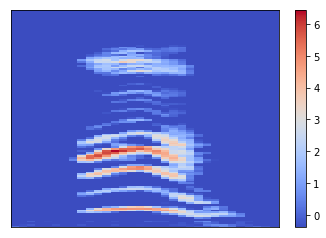

In [46]:
librosa.display.specshow(x_train_2[0])
plt.colorbar()

### Mexican Hat Network

In [39]:
x = tf.placeholder(dtype = tf.float32, shape = (None,freq_res,frames), name = 'x_input')
y = tf.placeholder(dtype = tf.float32, shape = (None,n_classes), name = 'labels')

d_1 = tf.get_variable(name = 'dilation_1',dtype = tf.float32,
                      initializer=tf.constant(0.2, dtype = tf.float32))
t_1 = tf.get_variable(name = 'translation_1', dtype = tf.float32,
                      initializer=tf.constant(0.0, dtype = tf.float32))

In [40]:
def mexican_hat_wt(x,d,t):
    x = (x-t)
    tf_pi = tf.constant(np.pi,dtype=tf.float32)
    #f = tf.constant(0.1, dtype = tf.float32)
    #return (1-x**2)*tf.exp(-x**2)
    return (1-2*(tf_pi**2)*(d**2)*(x**2))*tf.exp(-(tf_pi**2)*(d**2)*x**2)

In [41]:
x_new = tf.expand_dims(x,axis = -1)

z_1 = tf.layers.conv2d(x_new,186,[24,32],
                       padding = 'valid',
                       strides = [12,1],
                       activation=None)

a_1 = mexican_hat_wt(z_1,d_1,t_1)

flat = tf.layers.flatten(a_1)

fc_a_1 = tf.layers.Dense(32,activation='relu')(flat)
fc_a_2 = tf.layers.Dense(128,activation='relu')(fc_a_1)
dropout_a_2 = tf.layers.Dropout(rate = 0.5)(fc_a_2)
fc_a_3 = tf.layers.Dense(128,activation='relu')(dropout_a_2)
dropout_a_3 = tf.layers.Dropout(rate = 0.5)(fc_a_3)


logits = tf.layers.Dense(n_classes)(dropout_a_3)
y_hat = tf.argmax(tf.nn.softmax(logits),axis = 1)

acc = tf.reduce_mean(tf.cast(tf.equal(y_hat,tf.argmax(y,axis = 1)),dtype = tf.float32))

In [42]:
loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y, logits=logits)
optimizer = tf.train.AdamOptimizer()

tr_step = optimizer.minimize(loss)

### Training

In [43]:
epochs = 100
split_size = 50
val_size = 1000

In [44]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    check = len(x_train_2)/split_size
        
    if check % 1 != 0:
        new_size = int(check)*split_size
        x_train_3 = x_train_2[:new_size]
        y_train_oh_3 = y_train_oh[:new_size]

        x_train_end = x_train_2[new_size:]
        y_train_end = y_train_oh[new_size:]

        x_batches = np.split(x_train_3,split_size)    
        y_batches = np.split(y_train_oh_3,split_size)

        x_batches.append(x_train_end)
        y_batches.append(y_train_end)

    else:

        x_batches = np.split(x_train_2,split_size)
        y_batches = np.split(y_train_oh,split_size)
    
    for i in range(epochs):
        print('Epoch: {}'.format(i+1))
        j = 0 
        
        for batch_x,batch_y in zip(x_batches,y_batches):
            #n = np.random.randint(0,1200)
            #plt.imshow(batch_x)
            run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
            this_acc,_ = sess.run([acc,tr_step],feed_dict = {x:batch_x,y:batch_y}, options=run_options)
            
            if j%1000 == 0 or j == split_size-1:
                
                idxs = np.random.randint(0,len(x_val_2),size=val_size)
                
                x_this_val = x_val_2[idxs]
                y_this_val = y_val_oh[idxs]
                
                this_test_acc = sess.run(acc, feed_dict = {x:x_this_val,y:y_this_val}, options=run_options)
                #this_d, this_t = sess.run([d_1,t_1])
                print('It {:d}:\tTrain Acc {:02.2f}%\n\tTest Acc {:02.2f}%\n'.format(j+1,this_acc*100,this_test_acc*100))  
                #print('d: {:01.2f}, t: {:01.2f}\n'.format(this_d,this_t))
            j+=1
    
    #check_values = np.linspace(-10,10,num = 784)
    #check_values = np.reshape(check_values,(1,784))

    #edo = sess.run(check_wt,feed_dict = {x:check_values})

Epoch: 1
It 1:	Train Acc 6.10%
	Test Acc 25.40%

It 50:	Train Acc 56.69%
	Test Acc 51.80%

Epoch: 2
It 1:	Train Acc 51.77%
	Test Acc 53.40%

It 50:	Train Acc 75.79%
	Test Acc 64.80%

Epoch: 3
It 1:	Train Acc 69.49%
	Test Acc 64.90%

It 50:	Train Acc 80.91%
	Test Acc 71.70%

Epoch: 4
It 1:	Train Acc 74.41%
	Test Acc 71.70%

It 50:	Train Acc 85.24%
	Test Acc 72.90%

Epoch: 5
It 1:	Train Acc 80.12%
	Test Acc 72.20%

It 50:	Train Acc 87.99%
	Test Acc 76.50%

Epoch: 6
It 1:	Train Acc 78.94%
	Test Acc 72.50%

It 50:	Train Acc 85.83%
	Test Acc 72.70%

Epoch: 7
It 1:	Train Acc 83.66%
	Test Acc 71.90%

It 50:	Train Acc 89.37%
	Test Acc 67.00%

Epoch: 8
It 1:	Train Acc 80.71%
	Test Acc 70.60%

It 50:	Train Acc 90.94%
	Test Acc 74.10%

Epoch: 9
It 1:	Train Acc 82.68%
	Test Acc 71.20%

It 50:	Train Acc 91.73%
	Test Acc 73.90%

Epoch: 10
It 1:	Train Acc 89.57%
	Test Acc 73.20%

It 50:	Train Acc 94.09%
	Test Acc 72.30%

Epoch: 11
It 1:	Train Acc 88.78%
	Test Acc 69.00%

It 50:	Train Acc 90.75%
	Test

It 50:	Train Acc 100.00%
	Test Acc 77.80%

Epoch: 90
It 1:	Train Acc 100.00%
	Test Acc 77.90%

It 50:	Train Acc 100.00%
	Test Acc 76.20%

Epoch: 91
It 1:	Train Acc 100.00%
	Test Acc 77.30%

It 50:	Train Acc 100.00%
	Test Acc 78.90%

Epoch: 92
It 1:	Train Acc 100.00%
	Test Acc 79.90%

It 50:	Train Acc 100.00%
	Test Acc 74.50%

Epoch: 93
It 1:	Train Acc 100.00%
	Test Acc 76.00%

It 50:	Train Acc 100.00%
	Test Acc 78.50%

Epoch: 94
It 1:	Train Acc 100.00%
	Test Acc 77.50%

It 50:	Train Acc 100.00%
	Test Acc 74.60%

Epoch: 95
It 1:	Train Acc 100.00%
	Test Acc 74.90%

It 50:	Train Acc 100.00%
	Test Acc 75.50%

Epoch: 96
It 1:	Train Acc 100.00%
	Test Acc 75.90%

It 50:	Train Acc 100.00%
	Test Acc 74.90%

Epoch: 97
It 1:	Train Acc 100.00%
	Test Acc 74.70%

It 50:	Train Acc 100.00%
	Test Acc 72.60%

Epoch: 98
It 1:	Train Acc 100.00%
	Test Acc 74.90%

It 50:	Train Acc 100.00%
	Test Acc 77.70%

Epoch: 99
It 1:	Train Acc 100.00%
	Test Acc 77.00%

It 50:	Train Acc 100.00%
	Test Acc 75.40%

Epoch: 

In [29]:
tf.reset_default_graph()

### ReLU Network

In [23]:
x_ = tf.placeholder(dtype = tf.float32, shape = (None,40,32), name = 'x_input_2')
y_ = tf.placeholder(dtype = tf.float32, shape = (None,12), name = 'labels_2')

In [24]:
def mexican_hat_wt(x,d,t):
    x = (x-t)
    tf_pi = tf.constant(np.pi,dtype=tf.float32)
    #f = tf.constant(0.1, dtype = tf.float32)
    #return (1-x**2)*tf.exp(-x**2)
    return (1-2*(tf_pi**2)*(d**2)*(x**2))*tf.exp(-(tf_pi**2)*(d**2)*x**2)

In [26]:
x_new = tf.expand_dims(x_,axis = -1)

a_1 = tf.layers.conv2d(x_new,186,[8,32],
                       padding = 'valid',
                       strides = [4,1],
                       activation='relu')

#a_1 = mexican_hat_wt(z_1,d_1,t_1)

flat = tf.layers.flatten(a_1)

fc_a_1 = tf.layers.Dense(32,activation='relu')(flat)
fc_a_2 = tf.layers.Dense(128,activation='relu')(fc_a_1)
dropout_a_2 = tf.layers.Dropout(rate = 0.5)(fc_a_2)
fc_a_3 = tf.layers.Dense(128,activation='relu')(dropout_a_2)
dropout_a_3 = tf.layers.Dropout(rate = 0.5)(fc_a_3)


logits = tf.layers.Dense(n_classes)(dropout_a_3)
y_hat = tf.argmax(tf.nn.softmax(logits),axis = 1)

acc = tf.reduce_mean(tf.cast(tf.equal(y_hat,tf.argmax(y_,axis = 1)),dtype = tf.float32))

In [27]:
loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_, logits=logits)
optimizer = tf.train.AdamOptimizer()

tr_step = optimizer.minimize(loss)

### Training

In [28]:
epochs = 100
split_size = 50
val_size = 1000

In [30]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    check = len(x_train_2)/split_size
        
    if check % 1 != 0:
        new_size = int(check)*split_size
        x_train_3 = x_train_2[:new_size]
        y_train_oh_3 = y_train_oh[:new_size]

        x_train_end = x_train_2[new_size:]
        y_train_end = y_train_oh[new_size:]

        x_batches = np.split(x_train_3,split_size)    
        y_batches = np.split(y_train_oh_3,split_size)

        x_batches.append(x_train_end)
        y_batches.append(y_train_end)

    else:

        x_batches = np.split(x_train_2,split_size)
        y_batches = np.split(y_train_oh,split_size)
    
    for i in range(epochs):
        print('Epoch: {}'.format(i+1))
        j = 0 
        
        for batch_x,batch_y in zip(x_batches,y_batches):
            #n = np.random.randint(0,1200)
            #plt.imshow(batch_x)
            run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
            this_acc,_ = sess.run([acc,tr_step],feed_dict = {x_:batch_x,y_:batch_y}, options=run_options)
            
            if j%1000 == 0 or j == split_size-1:
                
                idxs = np.random.randint(0,len(x_val_2),size=val_size)
                
                x_this_val = x_val_2[idxs]
                y_this_val = y_val_oh[idxs]
                
                this_test_acc = sess.run(acc, feed_dict = {x_:x_this_val,y_:y_this_val}, options=run_options)
                #this_d, this_t = sess.run([d_1,t_1])
                print('It {:d}:\tTrain Acc {:02.2f}%\n\tTest Acc {:02.2f}%\n'.format(j+1,this_acc*100,this_test_acc*100))  
                #print('d: {:01.2f}, t: {:01.2f}\n'.format(this_d,this_t))
            j+=1
    
    #check_values = np.linspace(-10,10,num = 784)
    #check_values = np.reshape(check_values,(1,784))

    #edo = sess.run(check_wt,feed_dict = {x:check_values})

Epoch: 1
It 1:	Train Acc 6.89%
	Test Acc 9.00%

It 50:	Train Acc 49.41%
	Test Acc 53.20%

Epoch: 2
It 1:	Train Acc 51.77%
	Test Acc 51.30%

It 50:	Train Acc 63.98%
	Test Acc 67.60%

Epoch: 3
It 1:	Train Acc 64.17%
	Test Acc 64.40%

It 50:	Train Acc 73.03%
	Test Acc 73.10%

Epoch: 4
It 1:	Train Acc 70.87%
	Test Acc 75.50%

It 50:	Train Acc 76.57%
	Test Acc 78.00%

Epoch: 5
It 1:	Train Acc 75.00%
	Test Acc 75.90%

It 50:	Train Acc 78.74%
	Test Acc 79.00%

Epoch: 6
It 1:	Train Acc 79.13%
	Test Acc 76.90%

It 50:	Train Acc 81.50%
	Test Acc 81.80%

Epoch: 7
It 1:	Train Acc 80.12%
	Test Acc 78.30%

It 50:	Train Acc 80.71%
	Test Acc 79.40%

Epoch: 8
It 1:	Train Acc 81.30%
	Test Acc 80.20%

It 50:	Train Acc 82.87%
	Test Acc 79.30%

Epoch: 9
It 1:	Train Acc 82.28%
	Test Acc 80.10%

It 50:	Train Acc 83.07%
	Test Acc 80.30%

Epoch: 10
It 1:	Train Acc 80.71%
	Test Acc 81.40%

It 50:	Train Acc 82.48%
	Test Acc 77.50%

Epoch: 11
It 1:	Train Acc 80.31%
	Test Acc 80.00%

It 50:	Train Acc 84.84%
	Test 

It 50:	Train Acc 100.00%
	Test Acc 81.60%

Epoch: 91
It 1:	Train Acc 100.00%
	Test Acc 81.50%

It 50:	Train Acc 98.62%
	Test Acc 81.40%

Epoch: 92
It 1:	Train Acc 98.82%
	Test Acc 82.30%

It 50:	Train Acc 99.61%
	Test Acc 84.20%

Epoch: 93
It 1:	Train Acc 98.62%
	Test Acc 82.10%

It 50:	Train Acc 98.82%
	Test Acc 82.40%

Epoch: 94
It 1:	Train Acc 99.02%
	Test Acc 81.30%

It 50:	Train Acc 99.61%
	Test Acc 81.50%

Epoch: 95
It 1:	Train Acc 99.02%
	Test Acc 81.00%

It 50:	Train Acc 98.43%
	Test Acc 80.20%

Epoch: 96
It 1:	Train Acc 99.21%
	Test Acc 83.30%

It 50:	Train Acc 99.21%
	Test Acc 81.70%

Epoch: 97
It 1:	Train Acc 98.23%
	Test Acc 83.30%

It 50:	Train Acc 99.02%
	Test Acc 83.10%

Epoch: 98
It 1:	Train Acc 98.43%
	Test Acc 81.30%

It 50:	Train Acc 99.21%
	Test Acc 81.30%

Epoch: 99
It 1:	Train Acc 99.21%
	Test Acc 79.20%

It 50:	Train Acc 99.41%
	Test Acc 81.70%

Epoch: 100
It 1:	Train Acc 99.21%
	Test Acc 82.70%

It 50:	Train Acc 97.83%
	Test Acc 82.40%



In [31]:
tf.reset_default_graph()

In [30]:
def cnn_one_fstride4_40(input_shape, n_classes,d,t):

    X_input = Input(input_shape)

    X = Lambda(lambda q: expand_dims(q, -1), name='expand_dims') (X_input)

    X = Conv2D(186,[8,32],padding = 'valid',strides=[4,1])(X)
    
    #X = mexican_hat_wt(X,d,t)
    X = Activation(relu)(X)

    X = Flatten()(X)

    X = Dense(32)(X)

    X = Dense(128)(X)
    X = Dropout(0.5)(X)
    X = Activation(relu)(X)

    X = Dense(128)(X)
    X = Dropout(0.5)(X)
    X = Activation(relu)(X)

    X = Dense(n_classes)(X)
    X = Activation(softmax)(X)

    model = Model(inputs = X_input, outputs = X)

    return model